# Librerias

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern
import pywt

# Imágenes

In [4]:
pre_path = "../../../../../../data/images/"
t2_path = pre_path + "10029/10029_1000029_t2w.mha"
adc_path = pre_path + "10029/10029_1000029_adc.mha"
dwi_path = pre_path + "10029/10029_1000029_hbv.mha"

In [5]:
t2_image = sitk.ReadImage(t2_path)
adc_image = sitk.ReadImage(adc_path)
dwi_image = sitk.ReadImage(dwi_path)

# Visualización

In [6]:
def visualize_image(image):
    fig, axes = plt.subplots (nrows = 2, ncols = 3, figsize = (10, 10))
    rect = fig.patch
    rect.set_facecolor('black')
    
    axes[0,0].imshow(sitk.GetArrayFromImage(image)[3,:,:], cmap='gray')
    axes[0,1].imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
    axes[0,2].imshow(sitk.GetArrayFromImage(image)[8,:,:], cmap='gray')
    axes[1,0].imshow(sitk.GetArrayFromImage(image)[10,:,:], cmap='gray')
    axes[1,1].imshow(sitk.GetArrayFromImage(image)[12,:,:], cmap='gray')
    axes[1,2].imshow(sitk.GetArrayFromImage(image)[14,:,:], cmap='gray')
    
    for ax in axes.flat:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(h_pad=-15, w_pad=1)

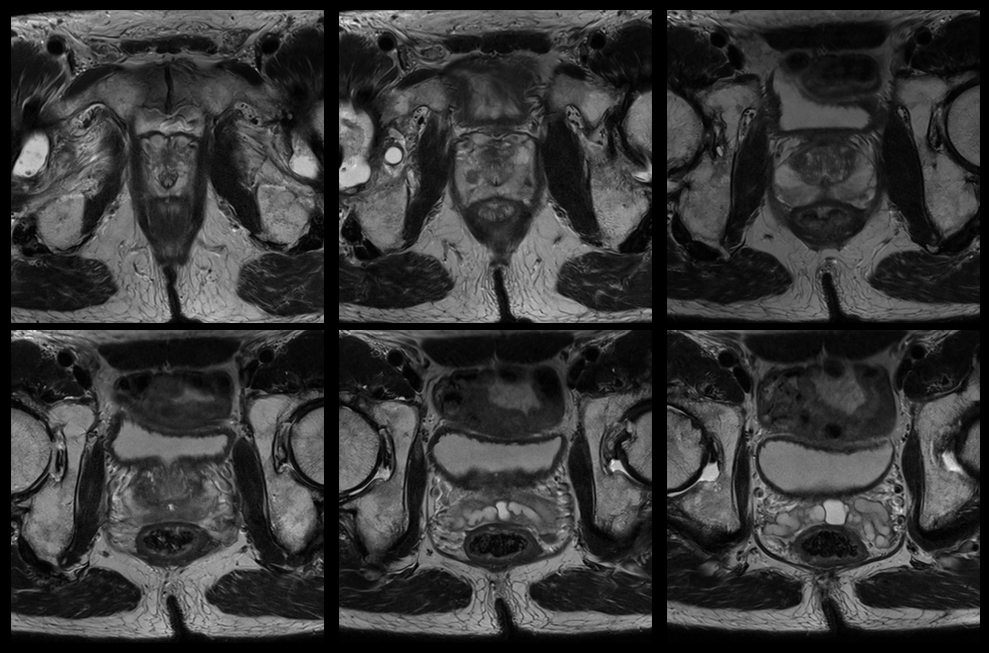

In [7]:
visualize_image(t2_image)

# Create a copy of the prostate image in float 64-bits

In [8]:
print(t2_image.GetPixelIDTypeAsString())
print(adc_image.GetPixelIDTypeAsString())
print(dwi_image.GetPixelIDTypeAsString())

16-bit unsigned integer
16-bit unsigned integer
16-bit unsigned integer


In [9]:
t2_image_float64 = sitk.Cast(t2_image, sitk.sitkFloat64)
adc_image_float64 = sitk.Cast(adc_image, sitk.sitkFloat64)
dwi_image_float64 = sitk.Cast(dwi_image, sitk.sitkFloat64)

# Filtros

In [13]:
def process_image(image_float64):
    """
    Aplica las siguientes transformaciones a la imagen:
      - Imagen original.
      - Filtros LoG (Laplacian Recursive Gaussian) con sigma=0.6, 2 y 3.
      - Operaciones: Exponential, Logarithm, Square y SquareRoot.
      - Transformada wavelet 2 niveles (se extraen los coeficientes del nivel 2).
    """
    # Filtros LoG para distintos sigma
    log_sigma_06 = sitk.LaplacianRecursiveGaussian(image_float64, sigma=0.6)
    log_sigma_2  = sitk.LaplacianRecursiveGaussian(image_float64, sigma=2)
    log_sigma_3  = sitk.LaplacianRecursiveGaussian(image_float64, sigma=3)
    
    # Operaciones matemáticas
    image_exponential = sitk.Exp(sitk.Normalize(image_float64))
    image_logarithm   = sitk.Log(image_float64)
    image_square      = sitk.Square(image_float64)
    image_sqrt        = sitk.Sqrt(image_float64)
    
    # Seleccionar una slice para la transformada wavelet
    im_arr_full = sitk.GetArrayFromImage(image_float64)
    if im_arr_full.shape[0] > 8:
        original_slice = im_arr_full[8, :, :]
    else:
        center = im_arr_full.shape[0] // 2
        original_slice = im_arr_full[center, :, :]
        
    # Transformada wavelet a 2 niveles usando 'bior1.3'
    coeffs = pywt.wavedec2(original_slice, 'bior1.3', level=2)
    # En coeffs, el primer elemento es la aproximación (LL) del nivel 2,
    # y el segundo contiene los coeficientes de detalle del nivel 2: (LH, HL, HH)
    wavelet = {
        'LL': coeffs[0],
        'LH': coeffs[1][0],
        'HL': coeffs[1][1],
        'HH': coeffs[1][2]
    }
    
    # Empaquetar resultados en un diccionario
    results = {
        'original': image_float64,
        'log': {
            '0.6': log_sigma_06,
            '2': log_sigma_2,
            '3': log_sigma_3
        },
        'exponential': image_exponential,
        'logarithm': image_logarithm,
        'square': image_square,
        'squareroot': image_sqrt,
        'wavelet': wavelet
    }
    return results

In [26]:
def plot_processed_images(results, slice_idx=8):
    """
    Muestra en una figura las transformaciones procesadas en una grilla de 2 filas x 6 columnas:
      1. Original
      2. LoG σ=0.6
      3. LoG σ=2
      4. LoG σ=3
      5. Exponential
      6. Logarithm
      7. Square
      8. SquareRoot
      9. Wavelet LL (Level 2)
      10. Wavelet LH (Level 2)
      11. Wavelet HL (Level 2)
      12. Wavelet HH (Level 2)
      
    Parámetros:
      results: diccionario con las imágenes procesadas (resultado de process_image).
      slice_idx: índice de la slice a visualizar (para imágenes 3D).
    """
    # Extraer la slice indicada de las imágenes (para operaciones con SimpleITK)
    original_arr    = sitk.GetArrayFromImage(results['original'])[slice_idx, :, :]
    log_arr_06      = sitk.GetArrayFromImage(results['log']['0.6'])[slice_idx, :, :]
    log_arr_2       = sitk.GetArrayFromImage(results['log']['2'])[slice_idx, :, :]
    log_arr_3       = sitk.GetArrayFromImage(results['log']['3'])[slice_idx, :, :]
    exponential_arr = sitk.GetArrayFromImage(results['exponential'])[slice_idx, :, :]
    logarithm_arr   = sitk.GetArrayFromImage(results['logarithm'])[slice_idx, :, :]
    square_arr      = sitk.GetArrayFromImage(results['square'])[slice_idx, :, :]
    squareroot_arr  = sitk.GetArrayFromImage(results['squareroot'])[slice_idx, :, :]
    
    # Los coeficientes wavelet ya son arrays 2D
    wavelet = results['wavelet']
    LL = wavelet['LL']
    LH = wavelet['LH']
    HL = wavelet['HL']
    HH = wavelet['HH']
    
    # Lista de títulos e imágenes en el orden deseado
    images = [
        ('Original', original_arr),
        ('LoG σ=0.6', log_arr_06),
        ('LoG σ=2', log_arr_2),
        ('LoG σ=3', log_arr_3),
        ('Exponential', exponential_arr),
        ('Logarithm', logarithm_arr),
        ('Square', square_arr),
        ('SquareRoot', squareroot_arr),
        ('Wavelet LL (Level 2)', LL),
        ('Wavelet LH (Level 2)', LH),
        ('Wavelet HL (Level 2)', HL),
        ('Wavelet HH (Level 2)', HH)
    ]
    
    # Configurar la grilla de 2 filas x 6 columnas
    fig, axes = plt.subplots(2, 6, figsize=(24, 8))
    fig.patch.set_facecolor('black')
    
    # Iterar sobre cada subplot asignando la imagen y su título
    for ax, (title, img) in zip(axes.flatten(), images):
        ax.imshow(img, cmap='gray')
        ax.set_title(title, color='w')
        ax.axis('off')
    
    fig.tight_layout()
    plt.show()

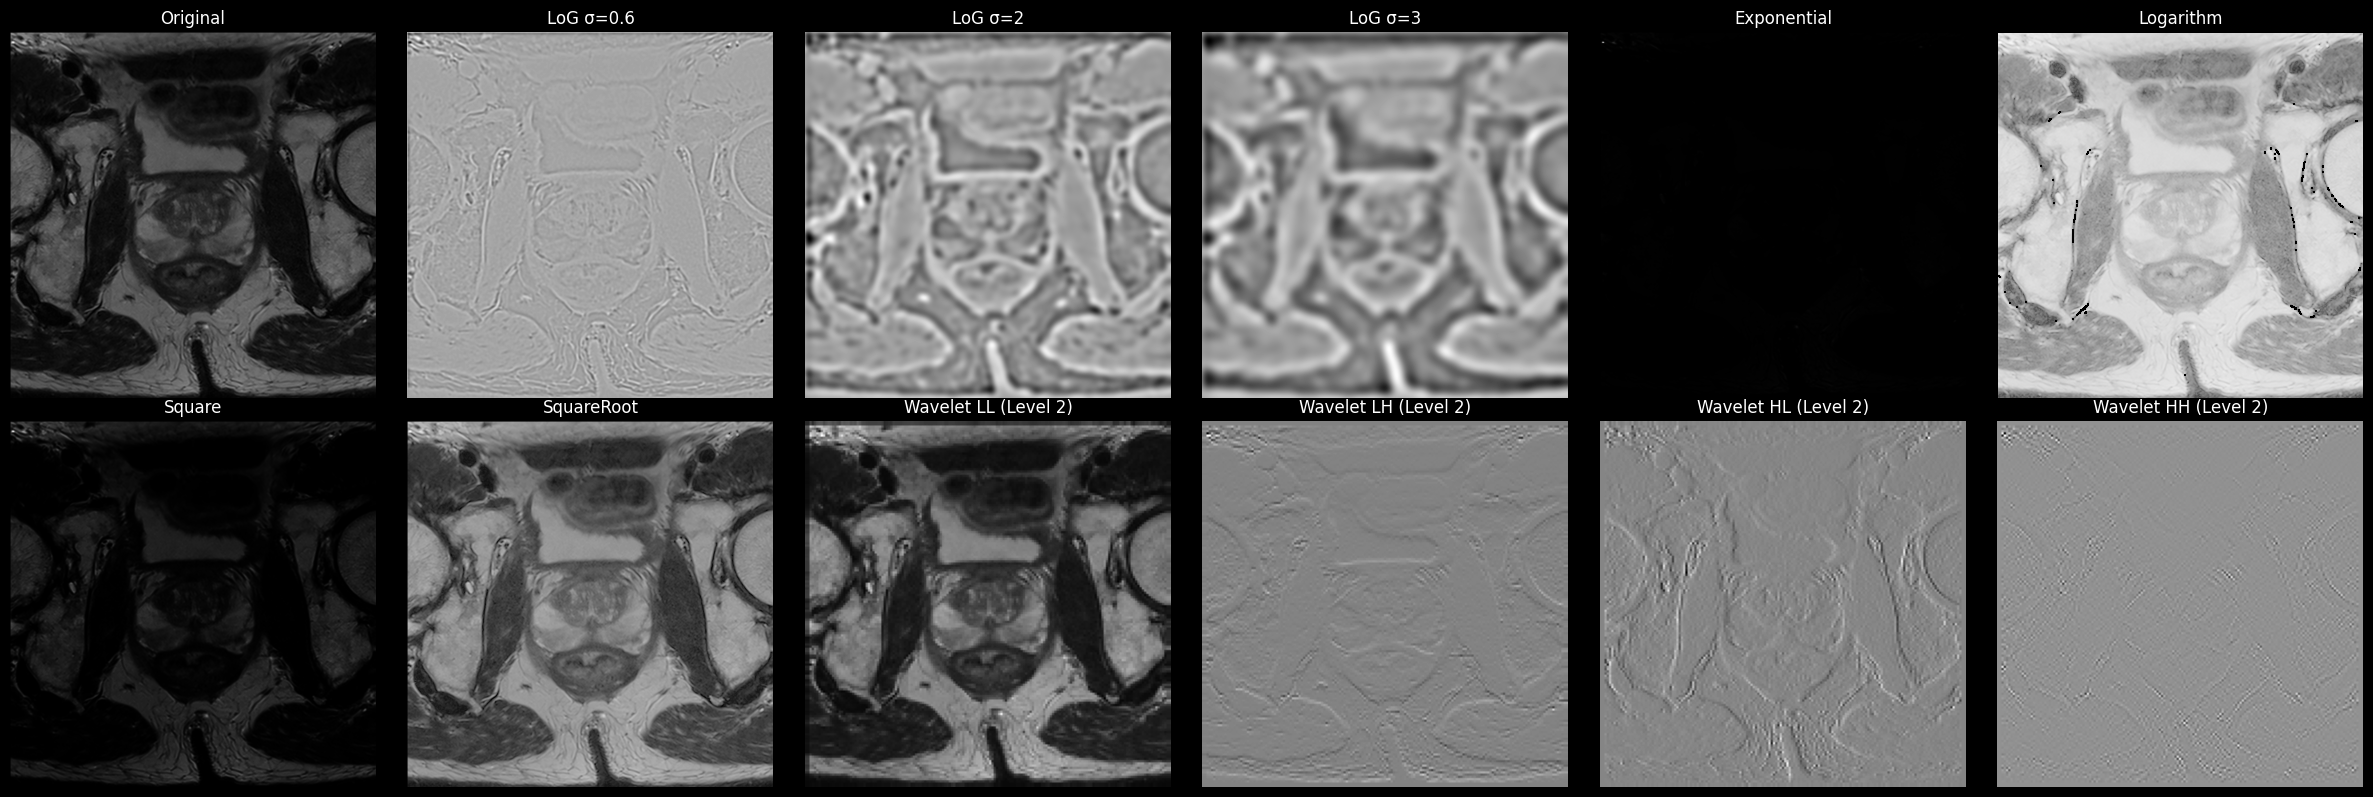

In [27]:
t2_results = process_image(t2_image_float64)
plot_processed_images(t2_results, slice_idx=8)

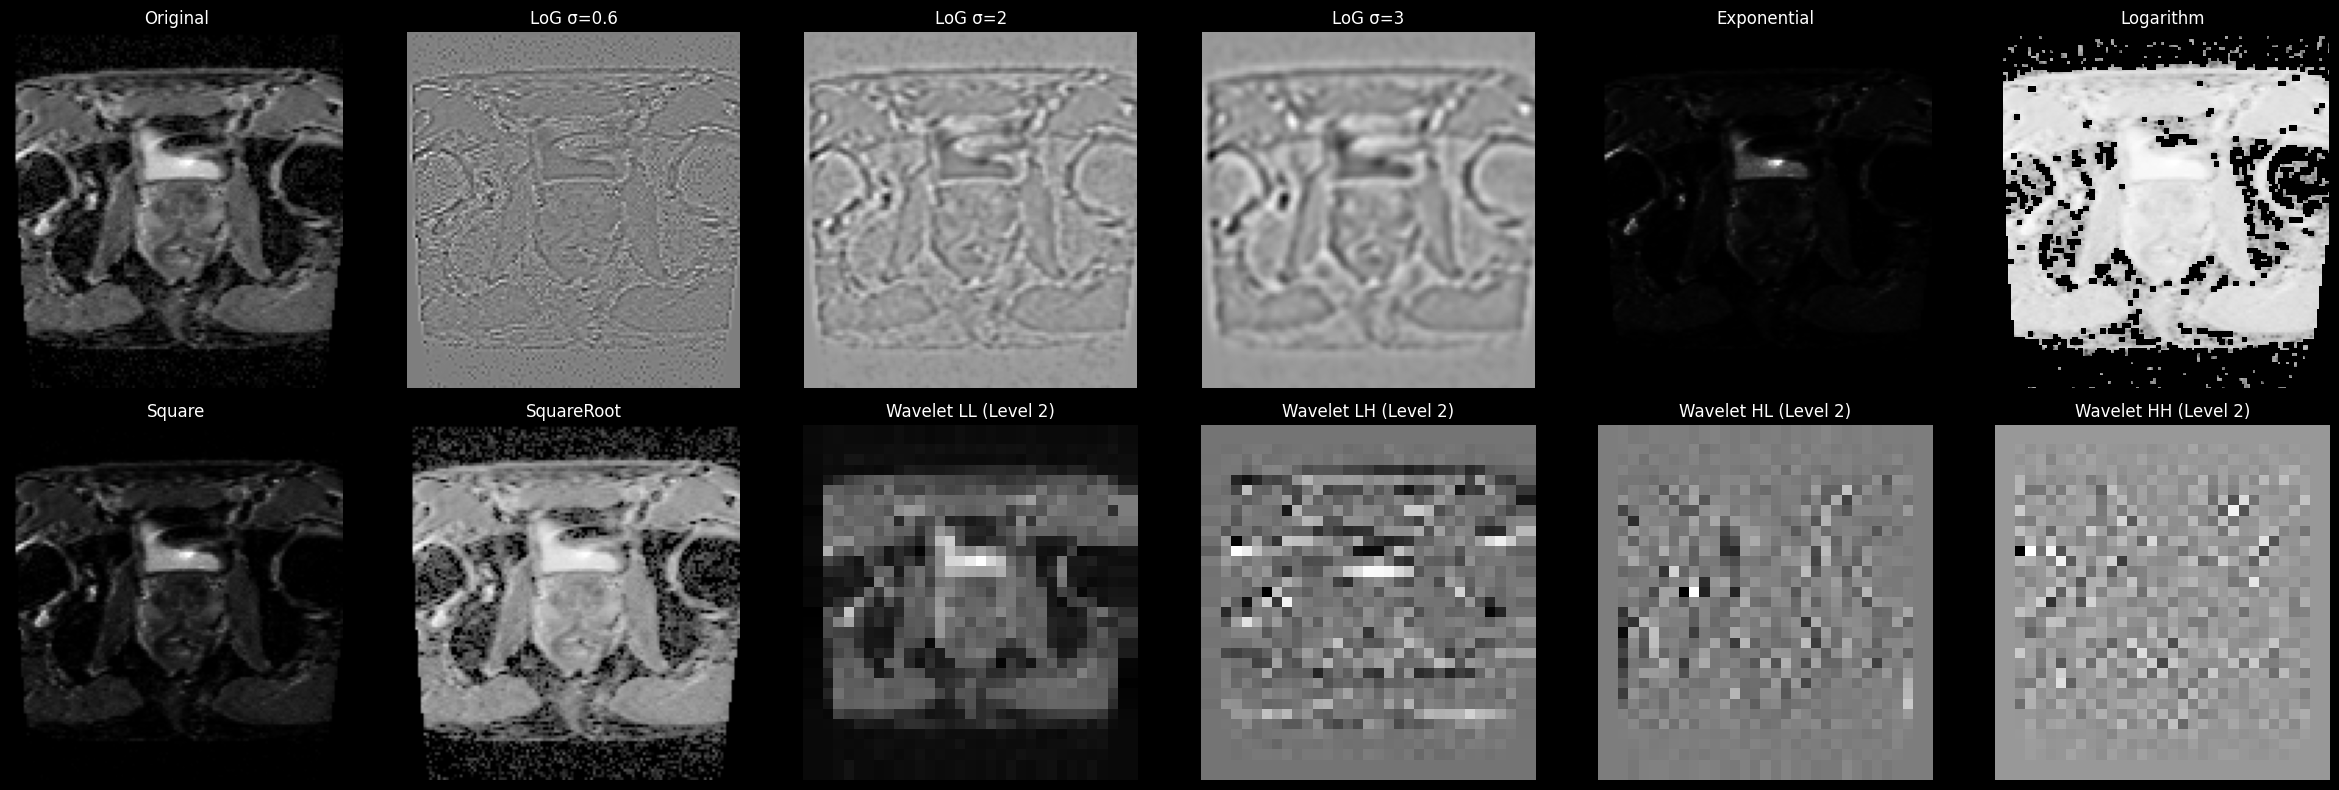

In [28]:
adc_results = process_image(adc_image_float64)
plot_processed_images(adc_results, slice_idx=8)

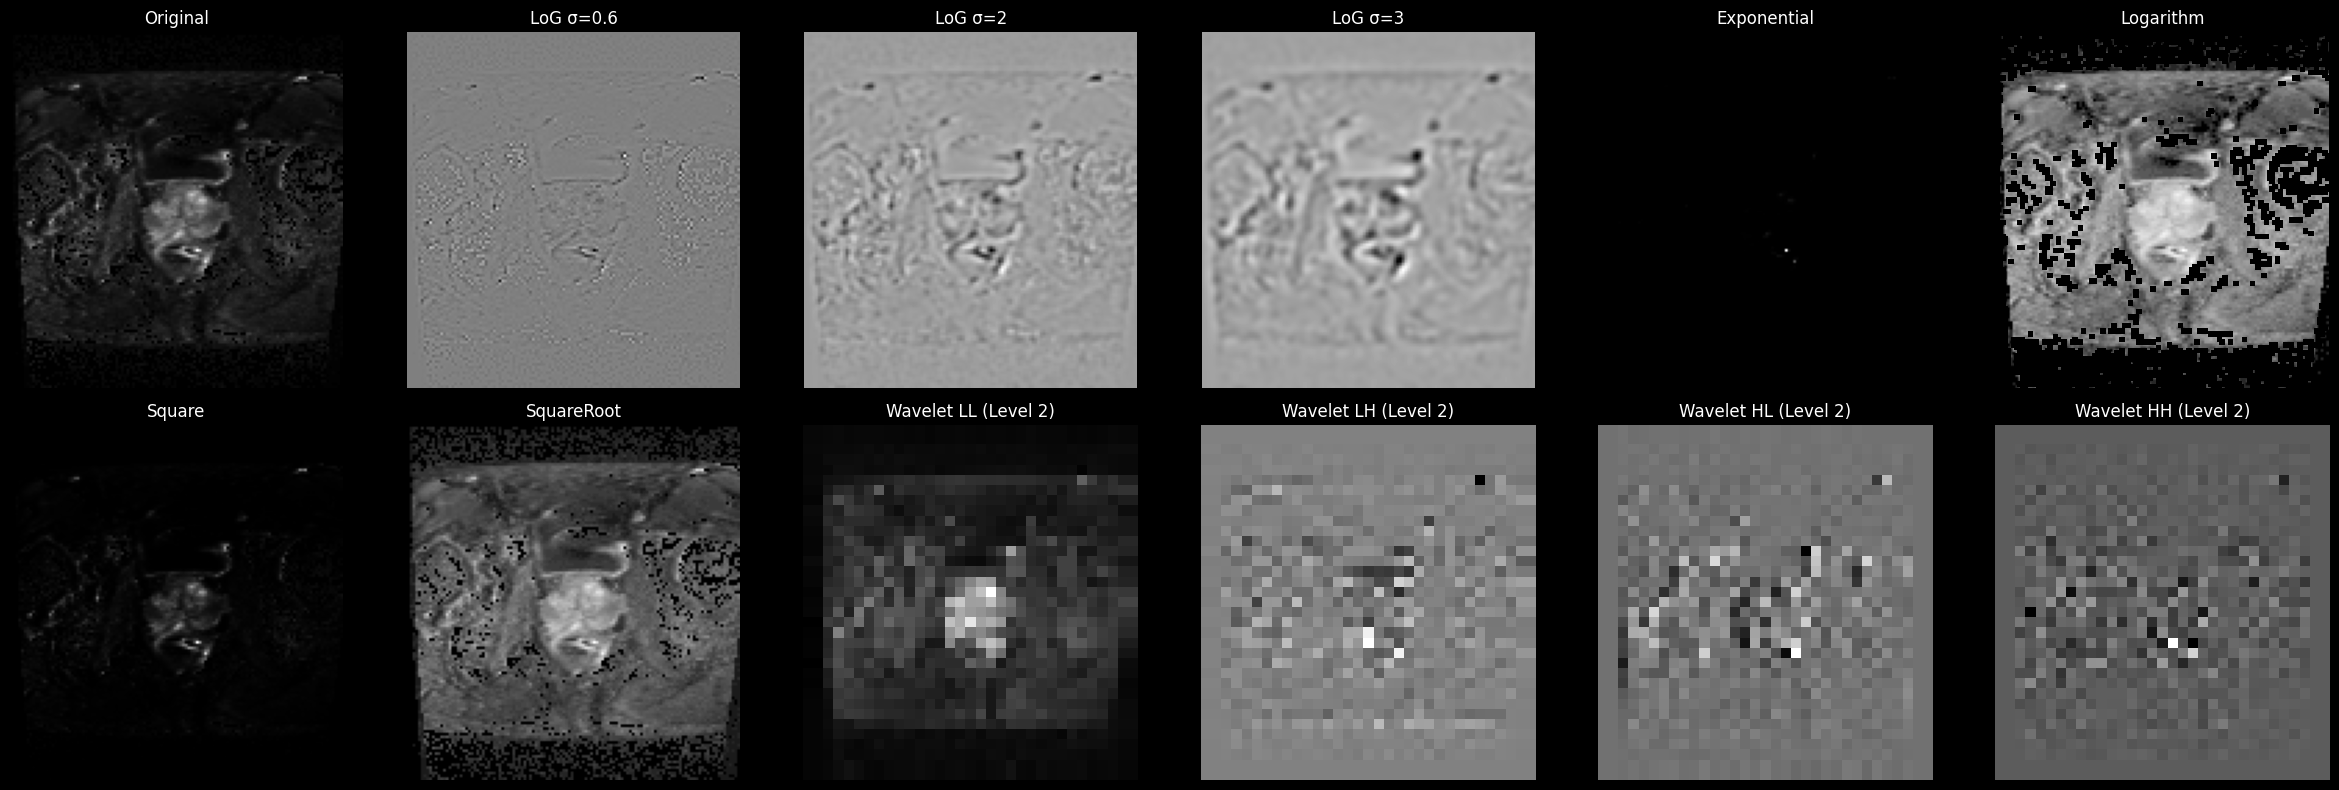

In [29]:
dwi_results = process_image(dwi_image_float64)
plot_processed_images(dwi_results, slice_idx=8)